#How To Build a Model: Step By Step


In [142]:
#Pytorch Imports
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.datasets import IMDB
from torchtext.transforms import ToTensor
from torchtext.vocab import build_vocab_from_iterator
#Pandas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
import time




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from transformers import AutoTokenizer

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

Pick Your Universal Hyperparamaters:

In [144]:
batch_size = 100
epochs = 5
input_dim = 512
n_filters= 128
filter_size = 5
hidden_dim = 100
output_dim = 11
embed_dim = 100
CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA=1
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
#device="cpu"
print(device)
print(torch.cuda.is_available())

cuda
True


# Setup Your Model Workspace:

Your model architecture, and all of it's relevent code, will go in a folder at the location ./NNDL/(Your Model Name Here)


# Setup Your Dataset/Data Loaders Here

Pytorch usually takes a csv file. You need to write a function( For naming convention let's call it *create_torch_datasets()* ) that takes the universal dataset we get from parsing and seperates/loads it into data that you want your model to train on




In [145]:
import json
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer

class JSONLTextDataset(Dataset):
    def __init__(self,
                 jsonl_file: str,
                 tokenizer_name: str = "bert-base-uncased",
                 text_key: str = "human_text",
                 max_length: int = 512,label: int = 1):
        """
        Args:
          jsonl_file: path to your .jsonl file
          tokenizer_name: HuggingFace model name
          text_key: which field to tokenize ("human_text" or "chatgpt_text")
          max_length: truncate/pad to this length
        """
        assert text_key in {"human_text", "machine_text"}, "text_key must be 'human_text' or 'machine_text'"
        self.label = label
        
        self.samples = []
        with open(jsonl_file, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                obj = json.loads(line)
                if text_key in obj:
                    self.samples.append(obj[text_key])  # raw text

        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text = self.samples[idx]
        encoded = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask = encoded["attention_mask"].squeeze(0)
        return input_ids, attention_mask, torch.tensor(self.label, dtype=torch.long), text


In [146]:
from torch.utils.data import random_split

# Create an instance of the dataset
# Note: You can use any JSONL file with the same structure
# For example, if you have a file named "reddit_chatGPT.jsonl" with the same structure
dataset = JSONLTextDataset(
    jsonl_file="./Data/reddit_chatGPT.jsonl",
    tokenizer_name="bert-base-uncased",
    text_key="human_text",   # or "machine_text"
    max_length=512,
    label=1
)

# 80/20 split
generator = torch.Generator().manual_seed(42)
train_len = int(0.8 * len(dataset))
test_len  = len(dataset) - train_len
h_train_ds, h_test_ds = random_split(dataset, [train_len, test_len], generator=generator)



In [147]:
# Create an instance of the dataset
# Note: You can use any JSONL file with the same structure
# For example, if you have a file named "reddit_chatGPT.jsonl" with the same structure
dataset = JSONLTextDataset(
    jsonl_file="./Data/reddit_chatGPT.jsonl",
    tokenizer_name="bert-base-uncased",
    text_key="machine_text",   # or "machine_text"
    max_length=512,
    label=0
)

# 80/20 split
generator = torch.Generator().manual_seed(42)
train_len = int(0.8 * len(dataset))
test_len  = len(dataset) - train_len
m_train_ds, m_test_ds = random_split(dataset, [train_len, test_len], generator=generator)


In [148]:
# Create your final dataloader with all the datasets combined that your model will use
from torch.utils.data import ConcatDataset

combined_train_ds = ConcatDataset([h_train_ds, m_train_ds])
combined_test_ds = ConcatDataset([h_test_ds, m_test_ds])

train_loader = DataLoader(combined_train_ds, batch_size=16, shuffle=True, drop_last=True)
test_loader  = DataLoader(combined_test_ds,  batch_size=16, shuffle=True, drop_last=True)


In [149]:
from transformers import BertTokenizer
import torch

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Unpack input_ids, attention_mask, and original text
input_ids, attention_mask,input_labe,original_text = train_loader.dataset[0]

# Convert tensor to list of tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.tolist())

# Print everything
print("Original Text:\n", original_text)
print("Tokens:\n", tokens)
print("Token IDs:\n", input_ids)
print("Input Label:\n", input_labe)


Original Text:
 It's really incredibly unlikely. Archaeologists have done a LOT of digging. We've drilled deep into the Earth's crust. We've mapped ocean floors.

We've found absolutely nothing to indicate this. Not only that, doing so would really throw a wrench into the entire fossil record and our evolutionary history. The tree of life would have to be completely revamped, and it would just be weird, because there is so much corroborating evidence for its current [basic] layout that something requiring a huge shift would mean that all of the current evidence is just coincidence--something that is incredibly unlikely.

Basically: we would have found something in the ground, something in the sea, and they probably would have machines orbiting the Earth. Despite exhaustive searches of our planet, we haven't found anything.

Remember the difference between an argument from ignorance and an argument from exclusion: I'm not saying that it doesn't exist because we haven't seen it; I'm sayi

### Check the shape, make sure it's how you want it.


tensor([[  101,  1045,  2572,  ...,     0,     0,     0],
        [  101,  2043,  2017,  ...,     0,     0,     0],
        [  101,  2043,  2009,  ...,     0,     0,     0],
        ...,
        [  101,  1037, 16571,  ...,  2021,  2008,   102],
        [  101,  2092,  1010,  ...,     0,     0,     0],
        [  101,  2009,  1005,  ..., 16557,  5488,   102]])
tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1])
Feature batch shape: torch.Size([16, 512])
Labels batch shape: torch.Size([16])


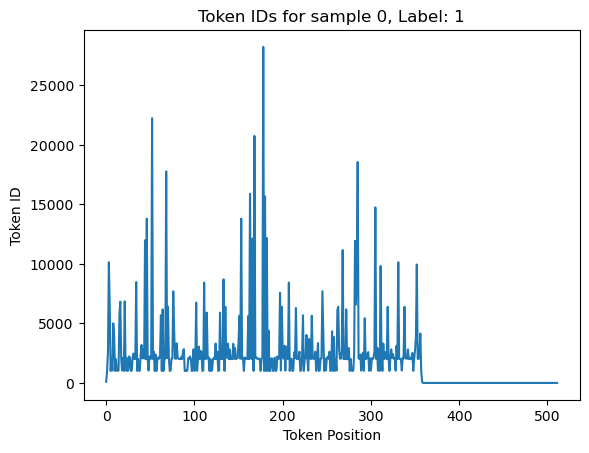

Label: 1


In [150]:
# Display image and label.
train_features, _,train_labels,_ = next(iter(train_loader))
print(train_features)
print(train_labels)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.plot(img.numpy())
plt.title(f"Token IDs for sample 0, Label: {label.item()}")
plt.xlabel("Token Position")
plt.ylabel("Token ID")
plt.show()
print(f"Label: {label}")

# Setup Model Architecture

1. Create your model architecture in your folder
2. Pick your loss function and optimizer

In [151]:
from Models.RNN import RNN,MyNetwork
from torchtext.vocab import GloVe
glove = GloVe(name='6B', dim=embed_dim)

#device = "cpu"
print(device)
model = MyNetwork(input_dim,n_filters,filter_size, 0.0, output_dim,embed_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


cuda


# Train the model
This should work to train your model. We may have to make some edits for different optimizations, but we can figure it out.


In [ ]:
# from ignite.handlers import FastaiLRFinder    

# lr_finder = FastaiLRFinder()
# to_save = {"model": model, "optimizer": optimizer}
# with lr_finder.attach(train, to_save=to_save) as trainer_with_lr_finder:
#     trainer_with_lr_finder.run(train_dataloader)

# # Get lr_finder results
# lr_finder.get_results()
 
# # Plot lr_finder results (requires matplotlib)
# lr_finder.plot()

# # get lr_finder suggestion for lr
# lr_finder.lr_suggestion()

Epoch 1
-------------------------------
loss: 1.918041  [   16/ 4800]
loss: 2.105541  [ 2064/ 4800]
loss: 2.168041  [ 4112/ 4800]
Progress: 1/75, Accuracy: 0.9%, Avg Loss: 1.855541
Progress: 2/75, Accuracy: 1.5%, Avg Loss: 1.980541
Progress: 3/75, Accuracy: 2.2%, Avg Loss: 1.980541
Progress: 4/75, Accuracy: 2.7%, Avg Loss: 2.043041
Progress: 5/75, Accuracy: 3.3%, Avg Loss: 2.043041
Progress: 6/75, Accuracy: 3.9%, Avg Loss: 2.053457
Progress: 7/75, Accuracy: 4.3%, Avg Loss: 2.078755
Progress: 8/75, Accuracy: 5.2%, Avg Loss: 2.050853
Progress: 9/75, Accuracy: 5.9%, Avg Loss: 2.049985
Progress: 10/75, Accuracy: 6.6%, Avg Loss: 2.049291
Progress: 11/75, Accuracy: 7.4%, Avg Loss: 2.037359
Progress: 12/75, Accuracy: 8.3%, Avg Loss: 2.022207
Progress: 13/75, Accuracy: 8.8%, Avg Loss: 2.038233
Progress: 14/75, Accuracy: 9.7%, Avg Loss: 2.025184
Progress: 15/75, Accuracy: 10.0%, Avg Loss: 2.043041
Progress: 16/75, Accuracy: 10.6%, Avg Loss: 2.046947
Progress: 17/75, Accuracy: 11.1%, Avg Loss: 2

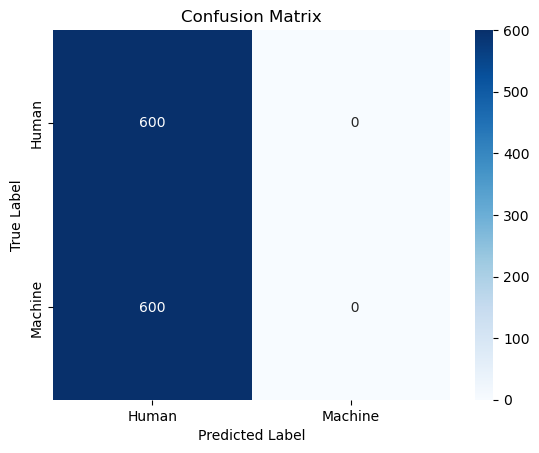


Test Accuracy: 50.0%
Average Test Loss: 2.043041
Epoch 2
-------------------------------
loss: 2.043041  [   16/ 4800]
loss: 1.918041  [ 2064/ 4800]
loss: 1.918041  [ 4112/ 4800]
Progress: 1/75, Accuracy: 0.8%, Avg Loss: 1.980541
Progress: 2/75, Accuracy: 1.5%, Avg Loss: 1.980541
Progress: 3/75, Accuracy: 2.1%, Avg Loss: 2.022207
Progress: 4/75, Accuracy: 2.7%, Avg Loss: 2.043041
Progress: 5/75, Accuracy: 3.3%, Avg Loss: 2.043041
Progress: 6/75, Accuracy: 3.9%, Avg Loss: 2.053457
Progress: 7/75, Accuracy: 4.8%, Avg Loss: 2.034112
Progress: 8/75, Accuracy: 5.4%, Avg Loss: 2.035228
Progress: 9/75, Accuracy: 6.1%, Avg Loss: 2.036096
Progress: 10/75, Accuracy: 6.8%, Avg Loss: 2.030541
Progress: 11/75, Accuracy: 7.4%, Avg Loss: 2.037359
Progress: 12/75, Accuracy: 8.3%, Avg Loss: 2.022207
Progress: 13/75, Accuracy: 9.1%, Avg Loss: 2.019002
Progress: 14/75, Accuracy: 10.0%, Avg Loss: 2.007326
Progress: 15/75, Accuracy: 10.5%, Avg Loss: 2.018041
Progress: 16/75, Accuracy: 11.2%, Avg Loss: 2.0

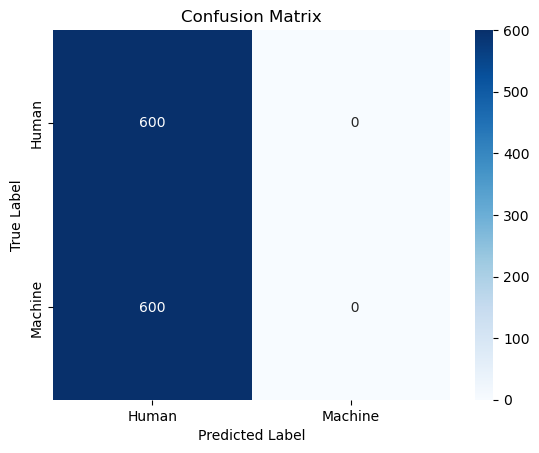


Test Accuracy: 50.0%
Average Test Loss: 2.043041
Epoch 3
-------------------------------
loss: 1.918041  [   16/ 4800]
loss: 2.105541  [ 2064/ 4800]
loss: 2.168041  [ 4112/ 4800]
Progress: 1/75, Accuracy: 0.4%, Avg Loss: 2.230541
Progress: 2/75, Accuracy: 0.9%, Avg Loss: 2.199291
Progress: 3/75, Accuracy: 1.6%, Avg Loss: 2.147207
Progress: 4/75, Accuracy: 2.3%, Avg Loss: 2.105541
Progress: 5/75, Accuracy: 3.1%, Avg Loss: 2.080541
Progress: 6/75, Accuracy: 3.4%, Avg Loss: 2.115957
Progress: 7/75, Accuracy: 4.2%, Avg Loss: 2.096612
Progress: 8/75, Accuracy: 4.8%, Avg Loss: 2.089916
Progress: 9/75, Accuracy: 5.5%, Avg Loss: 2.084707
Progress: 10/75, Accuracy: 5.9%, Avg Loss: 2.099291
Progress: 11/75, Accuracy: 6.7%, Avg Loss: 2.088495
Progress: 12/75, Accuracy: 7.6%, Avg Loss: 2.069082
Progress: 13/75, Accuracy: 8.2%, Avg Loss: 2.071887
Progress: 14/75, Accuracy: 9.2%, Avg Loss: 2.051969
Progress: 15/75, Accuracy: 9.4%, Avg Loss: 2.072207
Progress: 16/75, Accuracy: 10.2%, Avg Loss: 2.062

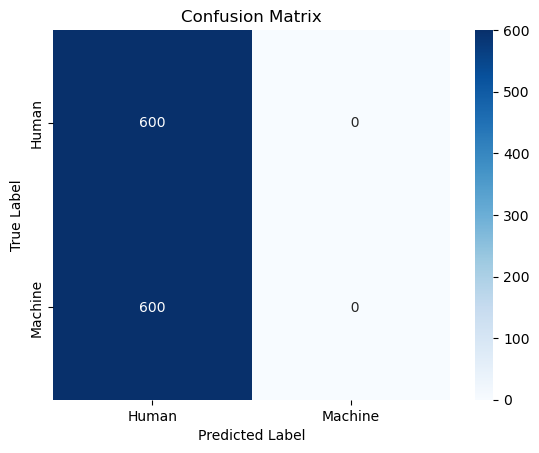


Test Accuracy: 50.0%
Average Test Loss: 2.043041
Epoch 4
-------------------------------
loss: 2.105541  [   16/ 4800]
loss: 2.043041  [ 2064/ 4800]
loss: 2.043041  [ 4112/ 4800]
Progress: 1/75, Accuracy: 0.8%, Avg Loss: 1.980541
Progress: 2/75, Accuracy: 1.2%, Avg Loss: 2.105541
Progress: 3/75, Accuracy: 2.0%, Avg Loss: 2.043041
Progress: 4/75, Accuracy: 2.6%, Avg Loss: 2.058666
Progress: 5/75, Accuracy: 3.1%, Avg Loss: 2.080541
Progress: 6/75, Accuracy: 3.7%, Avg Loss: 2.084707
Progress: 7/75, Accuracy: 4.5%, Avg Loss: 2.060898
Progress: 8/75, Accuracy: 5.2%, Avg Loss: 2.050853
Progress: 9/75, Accuracy: 6.2%, Avg Loss: 2.029152
Progress: 10/75, Accuracy: 6.7%, Avg Loss: 2.043041
Progress: 11/75, Accuracy: 7.4%, Avg Loss: 2.037359
Progress: 12/75, Accuracy: 8.1%, Avg Loss: 2.037832
Progress: 13/75, Accuracy: 8.9%, Avg Loss: 2.028618
Progress: 14/75, Accuracy: 9.8%, Avg Loss: 2.016255
Progress: 15/75, Accuracy: 10.3%, Avg Loss: 2.026374
Progress: 16/75, Accuracy: 11.1%, Avg Loss: 2.02

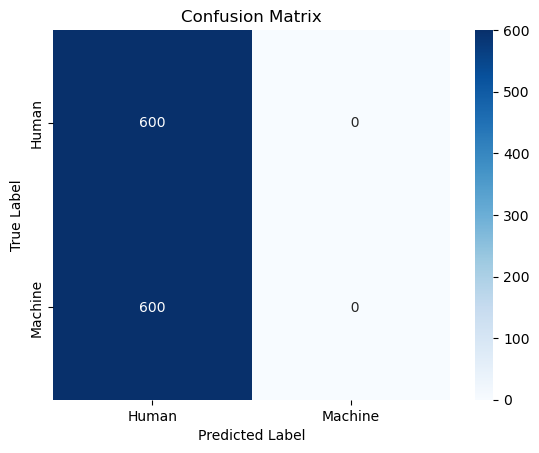


Test Accuracy: 50.0%
Average Test Loss: 2.043041
Epoch 5
-------------------------------
loss: 2.043041  [   16/ 4800]
loss: 2.105541  [ 2064/ 4800]
loss: 2.230541  [ 4112/ 4800]
Progress: 1/75, Accuracy: 0.3%, Avg Loss: 2.293041
Progress: 2/75, Accuracy: 1.4%, Avg Loss: 2.011791
Progress: 3/75, Accuracy: 2.2%, Avg Loss: 2.001374
Progress: 4/75, Accuracy: 2.8%, Avg Loss: 2.011791
Progress: 5/75, Accuracy: 3.5%, Avg Loss: 2.018041
Progress: 6/75, Accuracy: 4.0%, Avg Loss: 2.043041
Progress: 7/75, Accuracy: 4.8%, Avg Loss: 2.034112
Progress: 8/75, Accuracy: 5.4%, Avg Loss: 2.035228
Progress: 9/75, Accuracy: 6.3%, Avg Loss: 2.015263
Progress: 10/75, Accuracy: 7.3%, Avg Loss: 1.993041
Progress: 11/75, Accuracy: 8.1%, Avg Loss: 1.991904
Progress: 12/75, Accuracy: 8.7%, Avg Loss: 2.001374
Progress: 13/75, Accuracy: 9.2%, Avg Loss: 2.009387
Progress: 14/75, Accuracy: 9.9%, Avg Loss: 2.011791
Progress: 15/75, Accuracy: 10.7%, Avg Loss: 2.009707
Progress: 16/75, Accuracy: 11.2%, Avg Loss: 2.01

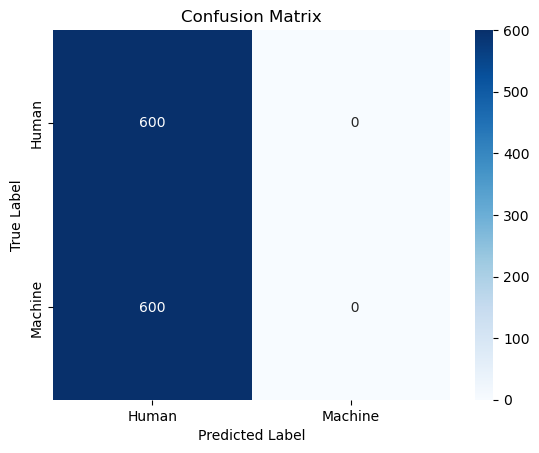


Test Accuracy: 50.0%
Average Test Loss: 2.043041
Done!


In [155]:
from Utils.Solver import train, test
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")